# **Distributed Database Management - Project B**



Technion – Israel Institute of Technology - Project Assignment 2 <br>
Shalom Mauda & Amit Machpud

## **Background**


In this project you are called to help the ”Distributed Human Health Association”.

The ”Distributed Human Health Association” is a health association that aims to improve the lifestyle
of humans in different ways. 
Recently, the association have started a project that works on improving

the health of people and combining different activities in their lifestyle.
In order to investigate different lifestyles, the association gathered information about the daily activities
of different people using smartphones and smartwatches.

You are requested to preform several tasks to help the ”Distributed Human Health Association”.



## **Data**


The dataset contains the readings of motion sensors commonly found in smartphones of several users. 
The readings were recorded while users executed activities scripted in no specific order carrying smartwatches
and smartphones.

The data consists of the following columns:
* Index: The row number.
* Arrival Time: The time the measurement arrived to the sensing application.
* Creation Time: The timestamp the OS attaches to the sample.
* x,y,z: The values provided by the sensor for the three axes, x,y,z.
* User: The user this sample originates from, the users names range from a to i.
* Model: The phone/watch model this sample originates from.
* Device: The specific device this sample is from. 
<br>They are prefixed with the model name and then the number, e.g., nexus4_1 or nexus4_2.
* Gt: The activity the user was performing: bike, sit, stand, walk, stairsup, stairsdown, and null.

The timestamps were measured according to unix time (number of seconds passed since 1970).

We will be working in this project with 2 types of the data: static and dynamic. In parts 1 and 2 We
will be working on the static data, meaning that We have all the data beforehand and the data will not change while you are working on it.
In part 3 We will work with dynamic data, meaning We will need to use spark streaming in order to
read the data and the data will change while We are working on it.

The dataset was published by:
Allan Stisen, Henrik Blunck, Sourav Bhattacharya, Thor Siiger Prentow, Mikkel Baun Kjærgaard, Anind
Dey, Tobias Sonne, and Mads Møller Jensen ”Smart Devices are Different: Assessing and Mitigating
Mobile Sensing Heterogeneities for Activity Recognition” In Proc. 13th ACM Conference on Embedded
Networked Sensor Systems (SenSys 2015), Seoul, Korea, 2015.

## **Assignment**



### **Data Analysis** (35 Points)
Investigate the data and derive 3 insights from the data. Try to think of insights based on different aspect
(time dimension, space dimension, etc). Use visualizations where applicable.


### **Learning Task** (30 Points)
Use the insights from the first part and build a Machine Learning model which utilizes the data from
your data store.
1. The task is to predict the activity variable (’gt’).
2. Define your training set and testing set (from your data store).
3. Create (build and train) a model using Spark MLlib. <br>
You can use a model that is composed of
several different models and utilize different learning techniques.
4. Evaluate your model using Accuracy (on train and test sets). 

If possible, through visualizations.
Your model should get at least 40 percent accuracy when training on 70 percent of the data and
testing on 30 percent of the data.

### **Extract and Learn** (35 Points)
Use Spark Streaming to extract the data from the data source. While streaming, train the ML model you
built in the previous task, while simultaneously testing it. Show the model’s performance throughout the
streaming process.

Constraint: We can not predict data that your model were trained on and you must predict all the data
(i.e. you can’t train the model on streamed data and then test the model on the same data).

---
# **Data Analysis**


Investigate the data and derive 3 insights from the data.<br>
Try to think of insights based on different aspect (time dimension, space dimension, etc).<br>
Use visualizations where applicable.

### **Init**

#### Code

In [ ]:
!pip install findspark
!pip install pyspark

In [ ]:
import findspark
import datetime
import matplotlib
import pandas as pd
import time

findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql import types as t

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie


def init_spark(app_name: str):
  spark = SparkSession.builder.appName(app_name).getOrCreate()
  sc = spark.sparkContext
  return spark, sc

spark, sc = init_spark('ProjectB')

In [ ]:
# load the data
df = spark.read.json("data.json")

# get hour in the day as a column
cast_to_hour = f.udf(lambda x: int(((x/1000) % 86400) / 3600))
df = df.withColumn('Hour', cast_to_hour(f.col('Arrival_Time')).cast('int'))

# get minute in the day as a column
cast_to_minute = f.udf(lambda x: int(((x/1000) % 3600) / 60))
df = df.withColumn('Minutes', cast_to_minute(f.col('Arrival_Time')).cast('int'))

#### Output

In [ ]:
df.show(5)
df.printSchema()
print(f'Number of records: {df.count()}')

+-------------+-------------------+--------+-----+------+----+-----+-------------+------------+-------------+----+-------+
| Arrival_Time|      Creation_Time|  Device|Index| Model|User|   gt|            x|           y|            z|Hour|Minutes|
+-------------+-------------------+--------+-----+------+----+-----+-------------+------------+-------------+----+-------+
|1424686735175|1424686733176178965|nexus4_1|   35|nexus4|   g|stand| 0.0014038086|   5.0354E-4|-0.0124053955|  10|     18|
|1424686735378|1424686733382813486|nexus4_1|   76|nexus4|   g|stand|-0.0039367676| 0.026138306|  -0.01133728|  10|     18|
|1424686735577|1424686733579072031|nexus4_1|  115|nexus4|   g|stand|  0.003540039|-0.034744263| -0.019882202|  10|     18|
|1424686735779|1424688581834321412|nexus4_2|  163|nexus4|   g|stand|  0.002822876| 0.005584717|  0.017318726|  10|     18|
|1424686735982|1424688582035859498|nexus4_2|  203|nexus4|   g|stand| 0.0017547607|-0.018981934| -0.022201538|  10|     18|
+-------------+-

### **Arrival Time**

#### Code

In [1]:
max_time = df.agg({"Creation_Time": "max"}).collect()[0][0]
min_time = df.agg({"Creation_Time": "min"}).collect()[0][0]
print(f"Hours different between max and min records: {max_time % 3600 - min_time % 3600}")

NameError: ignored

It can be seen that the difference between the maximum time and the lowest time was highlighted by about 42 hours.

In [ ]:
time_df = df.select('User', 'gt', 'Hour')
# get mean by space dimension
hour_meam = time_df.groupBy('gt').mean('Hour')
hour_meam = hour_meam.withColumn('avg(Hour)', f.col('avg(Hour)').cast('int'))
hour_meam.show()

It can be seen that in terms of the average time of day, it is difficult to determine the gt.

In [ ]:
# get Creation Time mean per user and gt
hour_pivot = df.groupBy("User").pivot("gt").mean('Hour')
gts = ['bike', 'null',  'sit', 'stairsdown', 'stairsup', 'stand', 'walk']
for gt in gts:
  hour_pivot = hour_pivot.withColumn(gt, f.col(gt).cast('int')).sort('User')
hour_pivot.show()

It can be seen that in terms of the average time of day, it is difficult to determine the gt per user.

In [ ]:
# plot gts by day time
plt.figure(figsize=(13,6))
pandas_df = df.select('Hour', 'User').sort('User').toPandas()
sns.countplot(data=pandas_df, x='Hour', hue='User')

#### Output


In [ ]:
# plot gts by day time
plt.figure(figsize=(13,6))
pandas_df = df.select('Hour', 'gt').sort('gt').toPandas()
sns.countplot(data=pandas_df, x='Hour', hue='gt')

### **Insight 1:**



> We looked at the histogram of users by gt's and saw that the amount of gt's per user is relevant and therefore we concluded that the column of users is important and significant for the prediction of the model.
---

### **Counts**

#### Code

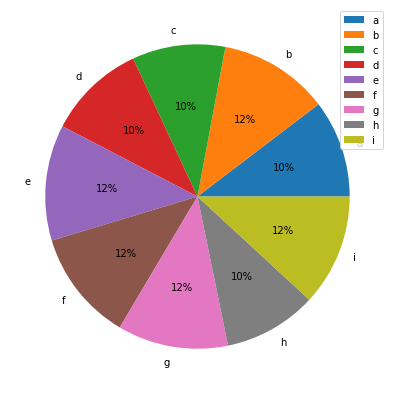

In [ ]:
# User count for all data
users = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
user_counts = df.groupBy("User").count().sort('User').toPandas()
plot_user = user_counts.plot.pie(y='count', figsize=(7, 7), label="", labels=users, autopct='%1.0f%%')

<br>
It can be seen that from each user was taken an almost equal amount of records.<br>
When users are numbered according to abc.<br>

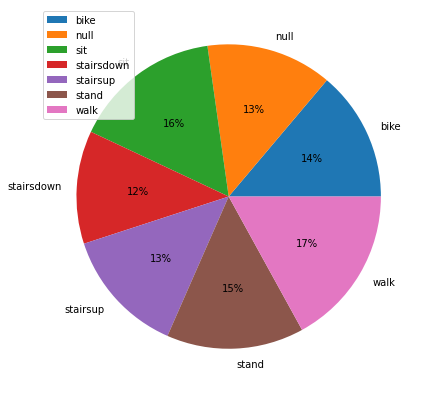

In [ ]:
# gt count for all data
gts = ['bike', 'null',  'sit', 'stairsdown', 'stairsup', 'stand', 'walk']
gt_counts = df.groupBy("gt").count().sort('gt').toPandas()
plot_user = gt_counts.plot.pie(y='count', figsize=(7, 7), autopct='%1.0f%%', label='', labels = gts)

It can be seen that from each gt was taken an almost equal amount of records.
<br>

In [ ]:
# gt per user count
user_gt = df.groupBy("User").pivot("gt").count().sort('User').show()

+----+-----+-----+-----+----------+--------+-----+-----+
|User| bike| null|  sit|stairsdown|stairsup|stand| walk|
+----+-----+-----+-----+----------+--------+-----+-----+
|   a| 7014| 5726|10458|      7315|    7567| 9793| 8722|
|   b|11192| 9654| 7644|      7630|    8638| 7756|11347|
|   c| 6041| 5446| 9156|      7042|    8603| 8113| 9604|
|   d| 7413| 4833| 9114|      6512|    8762| 9394|10840|
|   e|10136|12222| 9758|      6995|    7649| 9401|11060|
|   f| 9443| 9618| 9184|      7618|    8706| 9261|10612|
|   g| 7784|12254|10087|      6951|    6755| 9246|11098|
|   h| 7295| 4565|10519|      7448|    8050| 7532| 8722|
|   i| 9261| 8818|10243|      8046|    8432| 9198|10787|
+----+-----+-----+-----+----------+--------+-----+-----+



#### Output

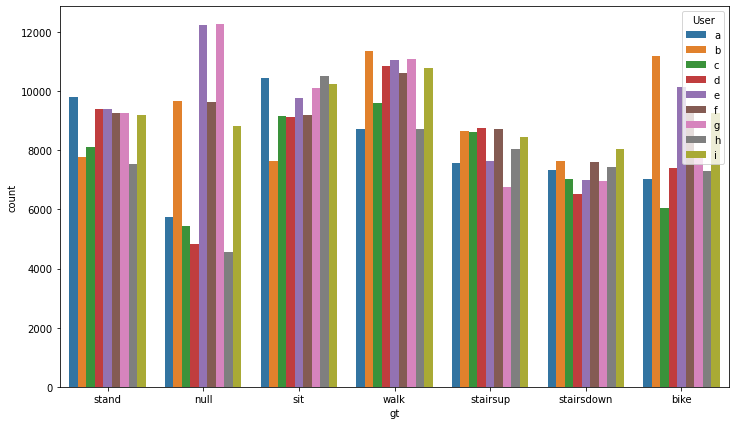

In [ ]:
# histogram of users count by gt
plt.figure(figsize=(12,7))
pandas_df = df.select('gt', 'User').sort('User').toPandas()
sns.countplot(data=pandas_df, x='gt', hue='User')

histograms for all users and gts. <br>
> ( Hour = 10   ==>   10 <= hour < 11 )

### **Insight 2:**


> According to the graph above showing the gt's histogram by time of day, there is a significant difference between the hours of the day and the gt's. As a consequence, we concluded that the time of day can aid in predicting the model, so we will add the time of day column to the model in order to get more accurate results. <br> We also added the minutes column in order to get more accurate results.

---

### **Model**

In [ ]:
# count Models types
model_df = df.select('Model').distinct()
model_df.show()
print(f"Number of models: {model_df.count()}")

+------+
| Model|
+------+
|nexus4|
+------+

Number of models: 1


### **Device**

In [ ]:
# count Device types
model_df = df.select('Device')
model_df_dist = model_df.distinct()
model_df.groupBy("Device").count().show()
print(f"Number of Devices: {model_df_dist.count()}")

+--------+------+
|  Device| count|
+--------+------+
|nexus4_1|270643|
|nexus4_2|275440|
+--------+------+

Number of Devices: 2


We can see ther is only two Devices: "nexus4_1", "nexus4_2".<br>
The two types are almost equal in quantity.
<br>

### **Insight 3:**


> It can be seen that there is only one type of model and therefore the information of the model will not affect the prediction of the model and therefore we will omit the column of the model. <br>
Unlike the model, the device itself has two types in the data, so we can use it as an additional feature that can help in the model's prediction operation.

---

### **Space Dimension**

##### Code

In [ ]:
import plotly.express as px

space_df = df.select('gt', 'x', 'y', 'z').toPandas()
space_mean = df.select('gt', 'x', 'y', 'z').groupBy('gt').mean().toPandas()

In [ ]:
# plot points for gts
toplot_df = space_df
fig1 = px.scatter_3d(toplot_df, x='x', y='y', z='z', color='gt', width=800, height=500)

# plot mean points for gts
toplot_df = space_mean
fig2 = px.scatter_3d(toplot_df, x='avg(x)', y='avg(y)', z='avg(z)', color='gt', width=500, height=350)

##### Output

In [ ]:
fig1.show()

As we can see from the chart

* 'stairsdown', 'stairsup' and 'bike', have a parse location.
* 'stand' and 'sit' are tight in their location compere to other gt's.

In [ ]:
fig2.show()

As we can see from the chart

* 'stairsdown', 'stairsup' and 'bike', have a distinguishable mean location.
* 'stand' and 'sit' have a close mean location compere to other gt's
* 'null' has a close mean location to 'sit', 'stand' and 'walk', meaning ןt is easy to confuse them.

In [ ]:
# plot gt's by axis
xy_df = df.select('gt', 'x', 'y').toPandas()
yz_df = df.select('gt', 'y', 'z').toPandas()
zx_df = df.select('gt', 'z', 'x').toPandas()

In [ ]:
# get figs of 2 axis by a time
fig_xy = px.scatter(xy_df, x='x', y='y', color='gt', title='X and Y',width=500, height=350)
fig_yz = px.scatter(yz_df, x='y', y='z', color='gt', title='Y and Z', width=500, height=350)
fig_zx = px.scatter(zx_df, x='z', y='x', color='gt', title='Z and X', width=500, height=350)

##### Output

In [ ]:
fig_xy.show()

In [ ]:
fig_yz.show()

In [ ]:
fig_zx.show()

### **Insight 4:**


> Our graphs above demonstrate that every gt's exhibits a different way of presenting itself, and we therefore believe that this can aid the model in predicting, so we'll include this information in the features.

---
# **Learning Task**


Use the insights from the first part and build a Machine Learning model which utilizes the data from your data store.

1. The task is to predict the activity variable (’gt’).
2. Define your training set and testing set (from your data store).
3. Create (build and train) a model using Spark MLlib. <br>
You can use a model that is composed of
several different models and utilize different learning techniques.
4. Evaluate your model using Accuracy (on train and test sets). 

If possible, through visualizations.
Your model should get at least 40 percent accuracy when training on 70 percent of the data and
testing on 30 percent of the data.

## Implementing the insights



From the insights of the last part we acknowledged a few things for this part.<br>


* According to the first insight we will use the users column.<br>
* According to the second insight we will use the hour and minute columns we created as features.<br>
* According to the third insight we will leave the column of the device and drop the column of the model.<br>
* According to the fourth insight we will use the information of x,y,z.
<br>

**Steps**:

* Remove unnecessary columns
* Trim device prefix and get 1 or 2 as int
* Device to int and reduce by 1
* Transform 'users', 'gt' and 'time' to index.
* From index columns of the above, transform to parse vectors.

In [ ]:
# get relevant columns
clean_df = df.select('gt', 'Index', 'User', 'Device', 'Model', 'Hour', 'Minutes', 'x', 'y', 'z')
# trim device prefix and get 1 or 2 as int
trim_prefix = f.udf(lambda x: x.split('_')[1])
clean_df = clean_df.withColumn('Device', trim_prefix(f.col('Device')).cast('int'))
clean_df = clean_df.withColumn('Device', f.col('Device') - 1)
data = clean_df

In [ ]:
from pyspark.ml import Pipeline
import pyspark.ml.feature as fe

transformer_pipeline = Pipeline(stages=[
    fe.StringIndexer(inputCols=["User", "gt", "Hour", "Minutes", "Device"],
                     outputCols=["user_index", "label", "hour_index", "minutes_index", "Device_index"]),
    fe.OneHotEncoder(inputCols=["hour_index", "minutes_index", "user_index", "Device_index"],
                     outputCols=["hour_vec", "minutes_vec", "user_vec", "Device_vec"]),
    fe.VectorAssembler(inputCols=["user_vec", "Device_vec", "hour_vec", "minutes_vec", "x", "y", "z"],
                       outputCol="features")
])
model = transformer_pipeline.fit(data)
prepared_df = model.transform(data)

train, test = prepared_df.randomSplit([0.7, 0.3])

### Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label",featuresCol="features")

fittedLR = lr.fit(train)
fittedLR.transform(test).select('gt', 'label', 'probability', 'prediction').show(5)

+----+-----+--------------------+----------+
|  gt|label|         probability|prediction|
+----+-----+--------------------+----------+
|bike|  3.0|[0.09097922141682...|       3.0|
|bike|  3.0|[0.09570186521635...|       3.0|
|bike|  3.0|[0.09633267779549...|       3.0|
|bike|  3.0|[0.10042486453223...|       3.0|
|bike|  3.0|[0.10202899563018...|       3.0|
+----+-----+--------------------+----------+
only showing top 5 rows



In [ ]:
print("Accuracy: ", fittedLR.summary.accuracy)

Accuracy:  0.8178835518873853


---
# **Extract and Learn**


Use Spark Streaming to extract the data from the data source.<br>
While streaming, train the ML model you built in the previous task, while simultaneously testing it.<br>
Show the model’s performance throughout the streaming process.

Constraint: We can not predict data that your model were trained on and you must predict all the data (i.e. you can’t train the model on streamed data and then test the model on the same data).